In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

<ipython-input-2-c74ebcd50faa>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(1,1,1)


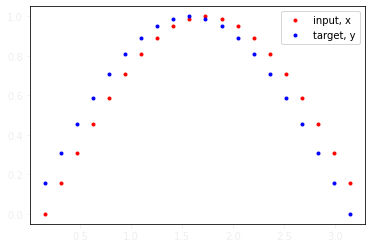

In [2]:
# how many time steps/data pts are in one batch of data
seq_length = 20

# generate evenly spaced data pts
time_steps = np.linspace(0, np.pi, seq_length + 1) #shape = 21
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension

x = data[:-1] # all but the last piece of data
y = data[1:] # all but the first

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y
# axes color
ax = plt.subplot(1,1,1)
ax.tick_params(axis = 'x', colors = '#efefef')
ax.tick_params(axis = 'y', colors = '#efefef')

plt.legend(loc='best')
plt.show()

In [3]:
class RNN(nn.Module):
  def __init__(self, input_size, output_size, hidden_size, num_layers):
    super().__init__()
    self.hidden_size = hidden_size # to be used in forward function

    # define an RNN with specified parameters
    # batch_first means that the first dim of the input and output will be the batch_size
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    # fully-connected layer
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, hidden):

    # x (batch_size, seq_length, input_size ie.,num of input features)
    # hidden (n_layers, batch_size, hidden_dim)
    # r_out (batch_size, time_step, hidden_size)
    batch_size = x.size(0)

    # get RNN outputs
    r_out, hidden = self.rnn(x, hidden)
    # shape output to be (batch_size*seq_length, hidden_dim)
    r_out = r_out.view(-1, self.hidden_size)

    # get final output
    output = self.fc(r_out)

    return output, hidden

In [4]:
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_size=10, num_layers=2)

# generate evenly spaced, test data pts
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))

test_input = torch.Tensor(data).unsqueeze(0)    # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())        # input_size - [batch_size, seq_length, input_size]

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())         # input_size - [batch_size, seq_length, input_size]
print('Hidden state size: ', test_h.size())     # input_size - [batch_size, seq_length, input_size]

Input size:  torch.Size([1, 20, 1])
Output size:  torch.Size([20, 1])
Hidden state size:  torch.Size([2, 1, 10])


In [5]:
# hyperparameters
input_size = 1
hidden_size = 32
output_size = 1
num_layers = 2

rnn = RNN(input_size, output_size, hidden_size, num_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [6]:
# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr = 0.01)

In [7]:
time_steps = np.linspace(0, np.pi, seq_length + 1) #shape = 21
data = np.sin(time_steps)
print(data, data.shape)
data.resize((seq_length+1 , 1))
print(data, data.shape)

[0.00000000e+00 1.56434465e-01 3.09016994e-01 4.53990500e-01
 5.87785252e-01 7.07106781e-01 8.09016994e-01 8.91006524e-01
 9.51056516e-01 9.87688341e-01 1.00000000e+00 9.87688341e-01
 9.51056516e-01 8.91006524e-01 8.09016994e-01 7.07106781e-01
 5.87785252e-01 4.53990500e-01 3.09016994e-01 1.56434465e-01
 1.22464680e-16] (21,)
[[0.00000000e+00]
 [1.56434465e-01]
 [3.09016994e-01]
 [4.53990500e-01]
 [5.87785252e-01]
 [7.07106781e-01]
 [8.09016994e-01]
 [8.91006524e-01]
 [9.51056516e-01]
 [9.87688341e-01]
 [1.00000000e+00]
 [9.87688341e-01]
 [9.51056516e-01]
 [8.91006524e-01]
 [8.09016994e-01]
 [7.07106781e-01]
 [5.87785252e-01]
 [4.53990500e-01]
 [3.09016994e-01]
 [1.56434465e-01]
 [1.22464680e-16]] (21, 1)


In [8]:
# Training
def train(rnn, n_steps, print_steps):
  #initialize hidden state
  hidden = None

  for batch_i, step in enumerate(range(n_steps)):
    #defining training data
    time_steps = np.linspace(step*np.pi, (step + 1)*np.pi, seq_length + 1)
    data = np.sin(time_steps)
    data.resize((seq_length + 1, 1))        # from shape(21,) to (21,1)

    x = data[:-1] # except last
    y = data[1:]  # except first

    # convert data to tensors
    x_tensor = torch.Tensor(x).unsqueeze(0) # changes x from (20, 1) to (1->batch_size, 20, 1)
    y_tensor = torch.Tensor(y)

    # outputs from the rnn
    prediction, hidden = rnn(x_tensor, hidden)

    ## Representing Memory ##
    # make a new variable for hidden and detach the hidden state from its history
    # this way, we don't backpropagate through the entire history
    hidden = hidden.data

    # calculate the loss
    loss = criterion(prediction, y_tensor)
    # zero gradients
    optimizer.zero_grad()
    # perform backprop and update weights
    loss.backward()
    optimizer.step()

    # display loss and predictions
    if batch_i%print_steps == 0:
      print('Loss: ', loss)
      plt.plot(time_steps[1:], x, 'r.') # input
      plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
      plt.show()

  return rnn

Loss:  tensor(0.6080, grad_fn=<MseLossBackward>)
Loss:  tensor(0.0090, grad_fn=<MseLossBackward>)
Loss:  tensor(0.0013, grad_fn=<MseLossBackward>)
Loss:  tensor(0.0016, grad_fn=<MseLossBackward>)
Loss:  tensor(0.0008, grad_fn=<MseLossBackward>)
Loss:  tensor(0.0007, grad_fn=<MseLossBackward>)
Loss:  tensor(0.0003, grad_fn=<MseLossBackward>)
Loss:  tensor(0.0004, grad_fn=<MseLossBackward>)
Loss:  tensor(0.0002, grad_fn=<MseLossBackward>)
Loss:  tensor(0.0003, grad_fn=<MseLossBackward>)


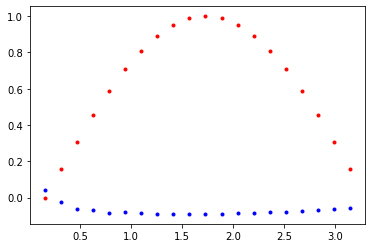

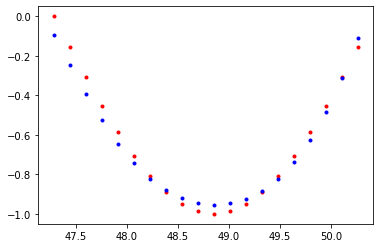

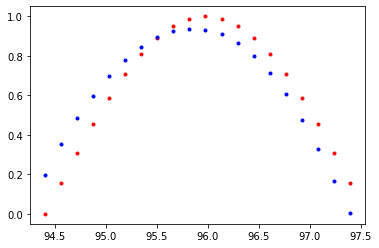

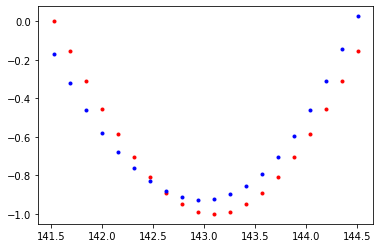

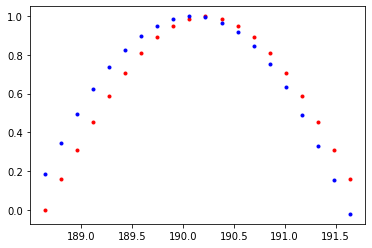

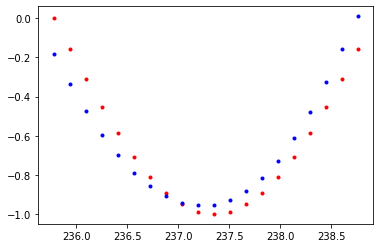

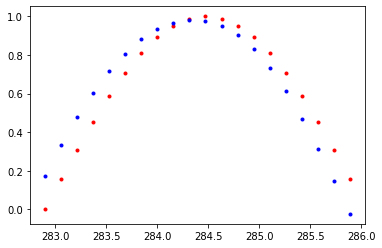

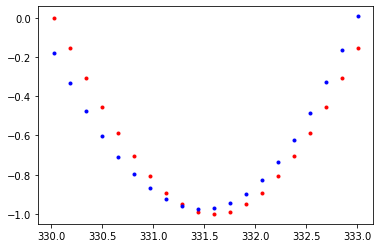

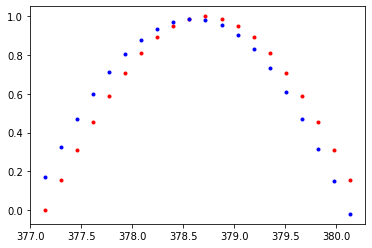

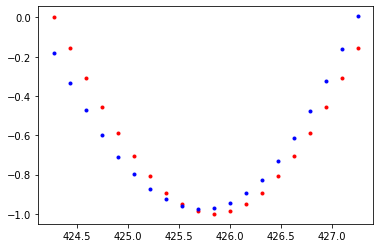

In [9]:
# train the rnn and monitor results
n_steps = 150
print_steps = 15

trained_rnn = train(rnn, n_steps, print_steps)